In [15]:
import deepxde as dde
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def gen_traindata():
    data = np.load("../dataset/Lorenz.npz")
    return data["t"], data["y"]

In [4]:
C1 = dde.Variable(1.0)
C2 = dde.Variable(1.0)
C3 = dde.Variable(1.0)


In [5]:
def Lorenz_system(x, y):
    """Lorenz system.
    dy1/dx = 10 * (y2 - y1)
    dy2/dx = y1 * (15 - y3) - y2
    dy3/dx = y1 * y2 - 8/3 * y3
    """
    y1, y2, y3 = y[:, 0:1], y[:, 1:2], y[:, 2:]
    dy1_x = dde.grad.jacobian(y, x, i=0)
    dy2_x = dde.grad.jacobian(y, x, i=1)
    dy3_x = dde.grad.jacobian(y, x, i=2)
    return [
        dy1_x - C1 * (y2 - y1),
        dy2_x - y1 * (C2 - y3) + y2,
        dy3_x - y1 * y2 + C3 * y3,
    ]


In [6]:
def boundary(_, on_initial):
    return on_initial

In [7]:
geom = dde.geometry.TimeDomain(0, 3)

In [8]:
ic1 = dde.icbc.IC(geom, lambda X: -8, boundary, component=0)
ic2 = dde.icbc.IC(geom, lambda X: 7, boundary, component=1)
ic3 = dde.icbc.IC(geom, lambda X: 27, boundary, component=2)

In [9]:
observe_t, ob_y = gen_traindata()

In [10]:
observe_y0 = dde.icbc.PointSetBC(observe_t, ob_y[:, 0:1], component=0)
observe_y1 = dde.icbc.PointSetBC(observe_t, ob_y[:, 1:2], component=1)
observe_y2 = dde.icbc.PointSetBC(observe_t, ob_y[:, 2:3], component=2)

In [11]:
data = dde.data.PDE(
    geom,
    Lorenz_system,
    [ic1, ic2, ic3, observe_y0, observe_y1, observe_y2],
    num_domain=400,
    num_boundary=2,
    anchors=observe_t,
)

Compiling model...
Building feed-forward neural network...
'build' took 0.047727 s



C:\Users\AS\AppData\Roaming\Python\Python39\site-packages\deepxde\nn\tensorflow_compat_v1\fnn.py:103: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  return tf.layers.dense(


'compile' took 0.467810 s

Initializing variables...
Training model...

Step      Train loss                                                                                    Test loss                                                                                     Test metric
0         [3.14e-02, 4.91e-02, 3.16e-01, 6.40e+01, 4.90e+01, 7.29e+02, 3.34e+01, 4.04e+01, 2.67e+02]    [3.14e-02, 4.91e-02, 3.16e-01, 6.40e+01, 4.90e+01, 7.29e+02, 3.34e+01, 4.04e+01, 2.67e+02]    []  
1000      [5.93e+00, 2.79e+00, 2.92e+00, 3.28e+01, 1.30e-03, 1.69e+00, 3.31e+01, 6.50e+00, 1.11e+01]    [5.93e+00, 2.79e+00, 2.92e+00, 3.28e+01, 1.30e-03, 1.69e+00, 3.31e+01, 6.50e+00, 1.11e+01]    []  
2000      [9.60e+00, 1.92e+00, 1.31e+00, 1.86e+01, 2.99e-01, 1.67e+00, 3.29e+01, 1.33e+01, 5.58e+00]    [9.60e+00, 1.92e+00, 1.31e+00, 1.86e+01, 2.99e-01, 1.67e+00, 3.29e+01, 1.33e+01, 5.58e+00]    []  
3000      [9.13e+00, 2.00e+00, 1.13e+00, 1.55e+01, 3.68e-01, 1.54e+00, 3.30e+01, 1.63e+01, 3.67e+00]    [9.13

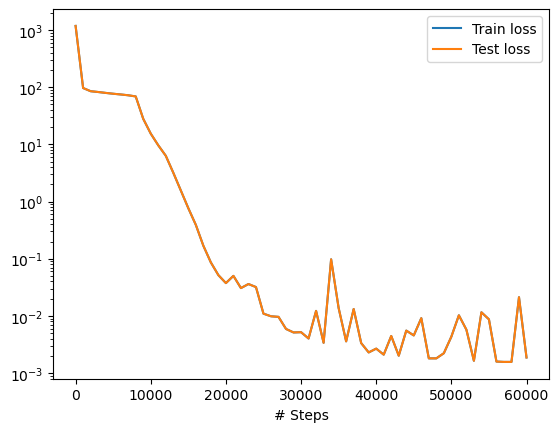

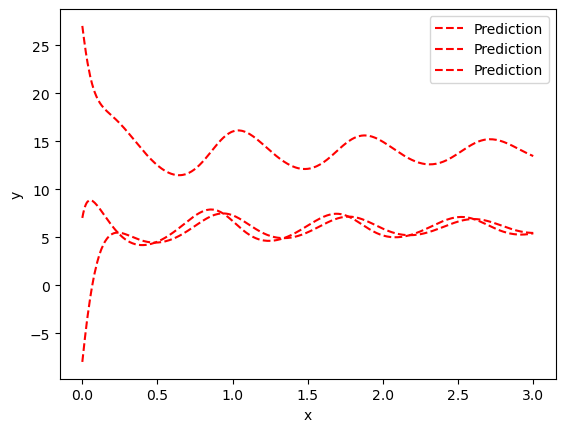

In [12]:

net = dde.nn.FNN([1] + [40] * 3 + [3], "tanh", "Glorot uniform")
model = dde.Model(data, net)
model.compile("adam", lr=0.001, external_trainable_variables=[C1, C2, C3])
variable = dde.callbacks.VariableValue(
    [C1, C2, C3], period=600, filename="variables.dat"
)
losshistory, train_state = model.train(iterations=60000, callbacks=[variable])
dde.saveplot(losshistory, train_state, issave=True, isplot=True)

In [13]:
fnamevar = "variables.dat"
variable = dde.callbacks.VariableValue([C1, C2, C3], period=100, filename=fnamevar)

In [16]:

# Plots
# reopen saved data using callbacks in fnamevar
lines = open(fnamevar, "r").readlines()
# read output data in fnamevar (this line is a long story...)
Chat = np.array(
    [
        np.fromstring(
            min(re.findall(re.escape("[") + "(.*?)" + re.escape("]"), line), key=len),
            sep=",",
        )
        for line in lines
    ]
)

l, c = Chat.shape
plt.plot(range(l), Chat[:, 0], "r-")
plt.plot(range(l), Chat[:, 1], "k-")
plt.plot(range(l), Chat[:, 2], "g-")
plt.plot(range(l), np.ones(Chat[:, 0].shape) * C1true, "r--")
plt.plot(range(l), np.ones(Chat[:, 1].shape) * C2true, "k--")
plt.plot(range(l), np.ones(Chat[:, 2].shape) * C3true, "g--")
plt.legend(["C1hat", "C2hat", "C3hat", "True C1", "True C2", "True C3"], loc="right")
plt.xlabel("Epoch")

yhat = model.predict(observe_t)
plt.figure()
plt.plot(observe_t, ob_y, "-", observe_t, yhat, "--")
plt.xlabel("Time")
plt.legend(["x", "y", "z", "xh", "yh", "zh"])
plt.title("Training data")
plt.show()

ValueError: not enough values to unpack (expected 2, got 1)